In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from sklearn import cross_validation
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(16, 8)

# Load and adjust the data

In [2]:
df_std1 = pd.read_csv('../data/std1_mh_11_pubchem_hmdb.csv', keep_default_na=False)
df_std2 = pd.read_csv('../data/std2_mh_11_pubchem_hmdb.csv', keep_default_na=False)

df_std1.drop(0, axis=0, inplace=True)
df_std1['JCHEM_ACIDIC_PKA'] = df_std1['JCHEM_ACIDIC_PKA'].astype(float)

for df in [df_std1, df_std2]:
    max_intensity = df['Dil_1_1'].max()
    df['Dil_1_1'] = df['Dil_1_1'] / max_intensity
    df['Dil_1_1'] = np.log(df['Dil_1_1'])

# Data preparation

In [3]:
# features = [
#     u'JCHEM_ACIDIC_PKA',
#     u'JCHEM_LOGP',
#     u'JCHEM_POLARIZABILITY',
#     u'JCHEM_POLAR_SURFACE_AREA',
# ]

# features = [
#     u'EXACT_MASS', 
#     u'ALOGPS_LOGP',
#     u'ALOGPS_LOGS', u'MOLECULAR_WEIGHT',
#     u'JCHEM_ACCEPTOR_COUNT',
#     u'JCHEM_ACIDIC_PKA', u'JCHEM_DONOR_COUNT',
#     u'JCHEM_LOGP', u'JCHEM_PHYSIOLOGICAL_CHARGE', u'JCHEM_POLARIZABILITY',
#     u'JCHEM_POLAR_SURFACE_AREA', u'JCHEM_REFRACTIVITY',
#     u'JCHEM_ROTATABLE_BOND_COUNT'
# ]

features = [
    u'JCHEM_ACIDIC_PKA',
    u'JCHEM_LOGP',
    u'JCHEM_POLARIZABILITY',
    u'JCHEM_POLAR_SURFACE_AREA',
]

X_train = df_std1
y_train = df_std1[['Dil_1_1']]

X_test = df_std2
y_test = df_std2[['Dil_1_1']]

print("Number of metabolites (training):", len(X_train))
print("Number of metabolites (testing):", len(X_test))

Number of metabolites (training): 52
Number of metabolites (testing): 39


In [4]:
X_train[features].head(3)

,JCHEM_ACIDIC_PKA,JCHEM_LOGP,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA
1,13.61,-1.8,8.93,60.69
2,8.93,-2.5,24.48,129.20
3,2.47,-1.2,17.20,63.32


# Fit Gaussian Process

In [5]:
kernel = GPy.kern.RBF(len(features), ARD=False)
model = GPy.models.GPRegression(X_train[features], y_train, kernel=kernel, normalizer=True)

model.optimize()

In [6]:
from IPython.display import display
display(model)

# Make predictions

In [7]:
mu_train, var_train = model.predict(X_train[features].as_matrix())
mu, var = model.predict(X_test[features].as_matrix())

In [8]:
X_test[features].describe()

,JCHEM_ACIDIC_PKA,JCHEM_LOGP,JCHEM_POLARIZABILITY,JCHEM_POLAR_SURFACE_AREA
count,39.000000,39.000000,39.000000,39.000000
mean,5.932051,-1.808154,16.790513,85.184103
std,4.398822,1.903884,6.821716,39.536552
min,0.990000,-4.900000,8.450000,34.140000
25%,2.240000,-3.650000,11.655000,59.280000
50%,3.820000,-1.500000,16.000000,67.480000
75%,9.965000,-0.425000,18.640000,92.420000
max,15.300000,1.900000,38.410000,186.070000


In [9]:
data = pd.concat([X_test, DataFrame(mu, columns=['Prediction'], index=X_test.index)], axis=1)

data[['Name', 'Dil_1_1', 'Prediction']]

,Name,Dil_1_1,Prediction
0,Hypoxanthine,-4.094681,-4.807323
1,Nicotinamide,-1.400545,-1.293431
2,5-Oxoproline,-4.334933,-1.173669
3,5'-Methylthioadenosine,-1.902766,-5.265852
4,L-Kynurenine,-3.940848,-5.194112
5,Adenosine,-2.332196,-5.251633
6,Guanosine,-7.944121,-5.251717
7,6-Methylaminopurine,-0.593049,-5.250191
8,L-isoleucine,-1.918242,-2.975759
9,Picolinic acid,-4.765880,-2.946602


In [10]:
y_true = data['Dil_1_1']
y_pred_new = data['Prediction']

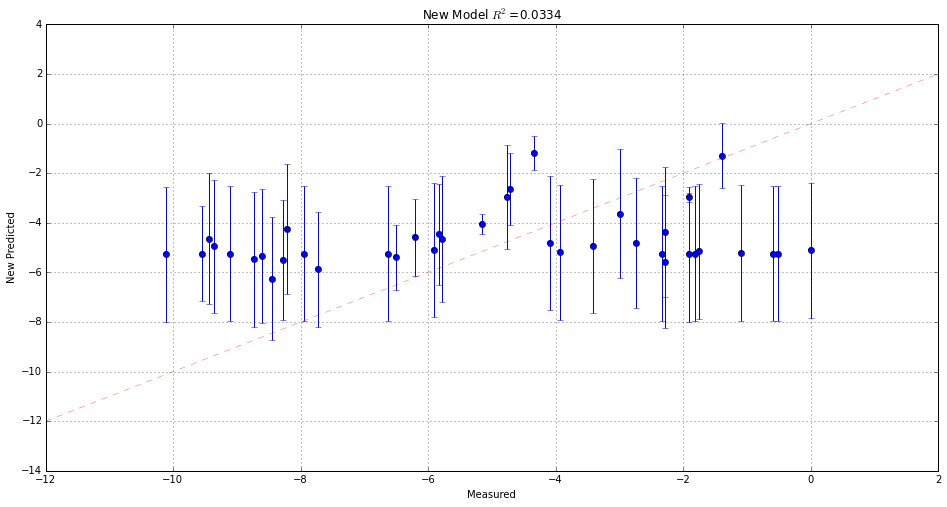

In [11]:
plt.clf()
plt.xlabel('Measured')
plt.ylabel('New Predicted')

plt.scatter(y_true, y_pred_new)
plt.errorbar(y_true, y_pred_new, yerr=np.sqrt(var), fmt='o')

xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

plt.grid(True)
plt.title('New Model $R^2$={:.4f}'.format(r2_score(y_true, y_pred_new)))

plt.show()

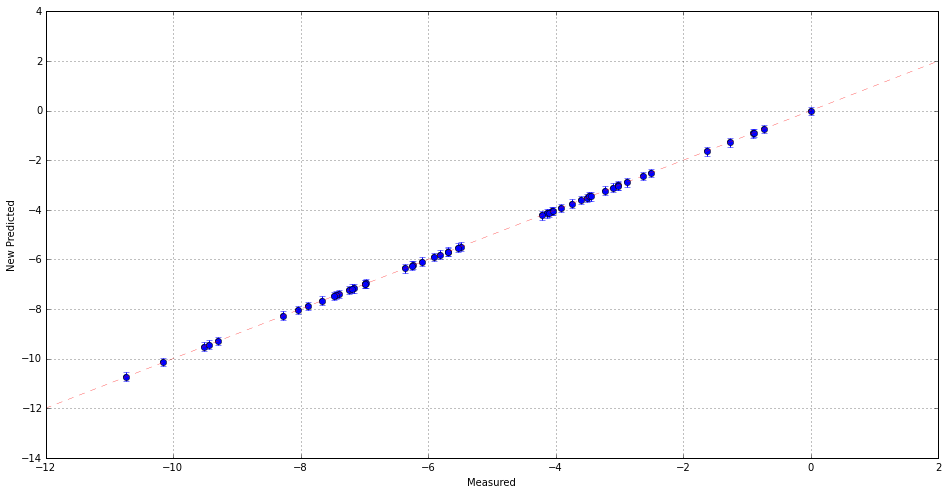

In [12]:
plt.clf()
plt.xlabel('Measured')
plt.ylabel('New Predicted')

plt.scatter(y_train['Dil_1_1'], mu_train)
plt.errorbar(y_train['Dil_1_1'], mu_train, yerr=np.sqrt(var_train), fmt='o')


xlim = plt.xlim()
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'r--', linewidth=.3)
plt.xlim(*xlim)

plt.grid(True)

plt.show()